In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treebank
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#import libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding

In [2]:
len(treebank.penn['train']) #characters

5101619

***Taking a subset of the whole dataset as the training data(150000 characters)***

In [3]:
data = treebank.penn['train']
data_test = data[:150000]

***Data Preprocessing (Cleaning)***

In [4]:
stop_words = set(stopwords.words('english'))
stop_words.add('unk')
stop_words.add('>')
stop_words.add('<')

word_tokens = word_tokenize(data_test)

filtered_sentence = [w for w in word_tokens if not w in stop_words]

print(word_tokens[10:50])
print(filtered_sentence[10:50])

['ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<', 'unk', '>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', 'mr.', '<', 'unk', '>', 'is', 'chairman', 'of', '<', 'unk']
['ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', 'N', 'years', 'old', 'join', 'board', 'nonexecutive', 'director', 'nov.', 'N', 'mr.', 'chairman', 'n.v.', 'dutch', 'publishing', 'group', 'rudolph', 'N', 'years', 'old', 'former', 'chairman', 'consolidated', 'gold', 'fields', 'plc']


In [5]:
data_f = " "
data_final = data_f.join(filtered_sentence)
print(len(data_final))

102176


***Creating a dictionary of words present in the training dataset***

In [6]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts([data_final])
encoded=tokenizer.texts_to_sequences([data_final])[0]

In [7]:
#define total vocabulary size
vocab_size=len(tokenizer.word_index)+1
vocab_size

3753

***Create seperate lists of 2 sequences since we will use one of them as input and one as output***

In [8]:

sequences=[]
num_features = 5
for i in range(len(encoded)-(num_features+1)):
    sequences.append(encoded[i:i+(num_features+1)])

In [9]:
#create dependent and independent variable
x=[]
y=[]
for i in range(len(sequences)):
    row = []
    [row.append(sequences[i][j]) for j in range(num_features)]
    x.append(row)
    y.append(sequences[i][num_features])

In [10]:
#convert list to an array
x=np.array(x)
y=np.array(y)

y=to_categorical(y,vocab_size)

In [11]:
# dataset splitting in train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9934, 5)
(4894, 5)
(9934, 3753)
(4894, 3753)


***Creating the Single Layer LSTM model***

In [12]:
#start building model
model=Sequential()

#add Embedding layer
model.add(Embedding(input_dim=vocab_size,output_dim=10,input_length=num_features))

#add LSTM layer
model.add(LSTM(60))

#output layer
model.add(Dense(vocab_size,activation='softmax'))

#compile 
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
#training model
history = model.fit(X_train,y_train,batch_size=1,epochs=50,validation_split=0.2)

Epoch 1/50
7947/7947 [==============================] - 49s 6ms/step - loss: 7.9189 - accuracy: 0.0420 - val_loss: 7.9881 - val_accuracy: 0.0453
Epoch 2/50
7947/7947 [==============================] - 36s 5ms/step - loss: 7.1467 - accuracy: 0.0508 - val_loss: 8.4648 - val_accuracy: 0.0513
Epoch 3/50
7947/7947 [==============================] - 36s 5ms/step - loss: 6.8172 - accuracy: 0.0570 - val_loss: 8.9828 - val_accuracy: 0.0483
Epoch 4/50
7947/7947 [==============================] - 36s 5ms/step - loss: 6.4610 - accuracy: 0.0696 - val_loss: 9.3538 - val_accuracy: 0.0518
Epoch 5/50
7947/7947 [==============================] - 36s 5ms/step - loss: 6.0378 - accuracy: 0.0797 - val_loss: 9.4470 - val_accuracy: 0.0493
Epoch 6/50
7947/7947 [==============================] - 36s 5ms/step - loss: 5.6474 - accuracy: 0.1027 - val_loss: 9.7126 - val_accuracy: 0.0498
Epoch 7/50
7947/7947 [==============================] - 36s 5ms/step - loss: 5.2196 - accuracy: 0.1326 - val_loss: 9.8140 - val_ac

In [14]:
def plot_loss_vs_epochs(fitted, num_epochs, modelname):
    accuracy = fitted.history['accuracy']
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, accuracy, 'g', label='Training loss')
    plt.title('Accuracy vs Epochs of ' + modelname)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


***Creating a function to predict `next_word` given `single` or a `list_of_words`***

In [15]:
#testing function
def predict_next_word(model,tokenizer,text,n_words, n_features):
    result=''
    out_word=[]
    
    for i in range(n_words):
        encoded_data_list = []
        for i in range(n_features):
            encoded_data=tokenizer.texts_to_sequences([text[i]])[0]            
            encoded_data_list.append(encoded_data[0])
            
        encoded_data_list=np.array(encoded_data_list)
        encoded_data_list=encoded_data_list.reshape(1,n_features)
        output=np.argmax(model.predict(encoded_data_list))
        
        
        for index,word in tokenizer.word_index.items():
            if word==output:
                out_word.append(index)
                text.append(index)
        text = text[1:]
    result=' '.join(out_word)
    return result

***Plotting accuracy vs number of epochs of Single Layer LSTM model***

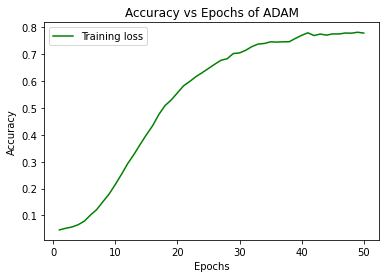

In [16]:
plot_loss_vs_epochs(history, 50, "ADAM")

In [17]:
loss_tr, accuracy_tr = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy:  {:.4f}".format(accuracy_tr)) 

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))        

Training Accuracy:  0.7205
Testing Accuracy:  0.0264


***OBSERVATION:***
> 
Training Accuracy of Single Layer LSTM : 72.05%
> 
Testing Accuracy of Single Layer LSTM : 2.64%

In [18]:
#testing 
predict_next_word(model,tokenizer,['jones', 'friday', 'industrial', 'average', 'stock'],10, num_features)

"years n rise n n month october first september 's"